In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/test_features.csv


In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [4]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(seed=42)

In [5]:
train_features = pd.read_csv('/kaggle/input/lish-moa/train_features.csv')
test_features = pd.read_csv('/kaggle/input/lish-moa/test_features.csv')
train_targets_scored = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('/kaggle/input/lish-moa/train_targets_nonscored.csv')
sample_submission = pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')

In [6]:
print('Train shape:',train_features.shape)
print('Test shape:',test_features.shape)

Train shape: (23814, 876)
Test shape: (3982, 876)


In [7]:
# prepare train_features
new_train_features = train_features.copy()
new_train_features

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,trt_cp,24,D2,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,...,0.1969,0.0262,-0.8121,0.3434,0.5372,-0.3246,0.0631,0.9171,0.5258,0.4680
23810,id_fffb70c0c,trt_cp,24,D2,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,...,0.4286,0.4426,0.0423,-0.3195,-0.8086,-0.9798,-0.2084,-0.1224,-0.2715,0.3689
23811,id_fffc1c3f4,ctl_vehicle,48,D2,0.3942,0.3756,0.3109,-0.7389,0.5505,-0.0159,...,0.5409,0.3755,0.7343,0.2807,0.4116,0.6422,0.2256,0.7592,0.6656,0.3808
23812,id_fffcb9e7c,trt_cp,24,D1,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,...,-0.1105,0.4258,-0.2012,0.1506,1.5230,0.7101,0.1732,0.7015,-0.6290,0.0740


In [8]:
# change cp_dose: D1 -> 0, D2 -> 1
new_train_features['cp_dose'] = new_train_features['cp_dose'].map({'D1':0, 'D2':1})
# change cp_time: 24 -> 0, 48 -> 1, 72 -> 2
new_train_features['cp_time'] = new_train_features['cp_time']//24-1
# drop the cp_type and sig_id column
new_train_features.drop(columns = ['sig_id','cp_type'], inplace = True)
new_train_features

,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,0,1,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,...,0.1969,0.0262,-0.8121,0.3434,0.5372,-0.3246,0.0631,0.9171,0.5258,0.4680
23810,0,1,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,-0.2252,-0.5565,...,0.4286,0.4426,0.0423,-0.3195,-0.8086,-0.9798,-0.2084,-0.1224,-0.2715,0.3689
23811,1,1,0.3942,0.3756,0.3109,-0.7389,0.5505,-0.0159,-0.2541,0.1745,...,0.5409,0.3755,0.7343,0.2807,0.4116,0.6422,0.2256,0.7592,0.6656,0.3808
23812,0,0,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,0.0323,0.0463,...,-0.1105,0.4258,-0.2012,0.1506,1.5230,0.7101,0.1732,0.7015,-0.6290,0.0740


In [9]:
new_train_targets_scored = train_targets_scored.copy()
# drop the sig_id column
new_train_targets_scored.drop(columns = ['sig_id'], inplace = True)
new_train_targets_scored

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23810,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23811,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23812,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
X = new_train_features
y = new_train_targets_scored
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((16669, 874), (7145, 874), (16669, 206), (7145, 206))

In [11]:
# Stop training when the validation loss metric has stopped decreasing for 5 epochs.
early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 3,
                               mode = 'min',
                               restore_best_weights = True)

In [12]:
def create_model(num_columns):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(num_columns),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tfa.layers.WeightNormalization(tf.keras.layers.Dense(2048, activation="relu")),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tfa.layers.WeightNormalization(tf.keras.layers.Dense(1024, activation="relu")),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tfa.layers.WeightNormalization(tf.keras.layers.Dense(512, activation="relu")),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tfa.layers.WeightNormalization(tf.keras.layers.Dense(206, activation="sigmoid"))
    ])
    model.compile(optimizer=tfa.optimizers.Lookahead(tf.optimizers.Adam(), sync_period=10),
                  loss='binary_crossentropy')
    return model

In [13]:
model = create_model(X_train.shape[1])
history = model.fit(x = X_train, 
                    y = y_train, 
                    validation_data = (X_test, y_test), 
                    epochs = 35, 
                    verbose = 1, 
                    callbacks = [early_stopping])

Epoch 1/35
521/521 [==============================] - 6s 12ms/step - loss: 0.3309 - val_loss: 0.0398
Epoch 2/35
521/521 [==============================] - 5s 10ms/step - loss: 0.0287 - val_loss: 0.0214
Epoch 3/35
521/521 [==============================] - 6s 11ms/step - loss: 0.0217 - val_loss: 0.0196
Epoch 4/35
521/521 [==============================] - 5s 10ms/step - loss: 0.0201 - val_loss: 0.0188
Epoch 5/35
521/521 [==============================] - 6s 12ms/step - loss: 0.0195 - val_loss: 0.0182
Epoch 6/35
521/521 [==============================] - 6s 11ms/step - loss: 0.0187 - val_loss: 0.0177
Epoch 7/35
521/521 [==============================] - 6s 11ms/step - loss: 0.0181 - val_loss: 0.0173
Epoch 8/35
521/521 [==============================] - 6s 12ms/step - loss: 0.0177 - val_loss: 0.0171
Epoch 9/35
521/521 [==============================] - 6s 12ms/step - loss: 0.0172 - val_loss: 0.0167
Epoch 10/35
521/521 [==============================] - 6s 11ms/step - loss: 0.0169 - val_lo

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 874)               3496      
_________________________________________________________________
dropout (Dropout)            (None, 874)               0         
_________________________________________________________________
weight_normalization (Weight (None, 2048)              3586049   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
weight_normalization_1 (Weig (None, 1024)              4197377   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4

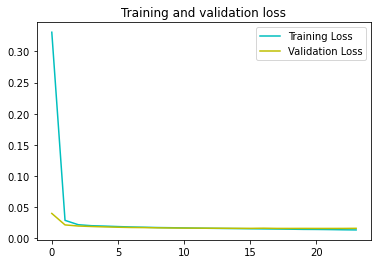

In [15]:
# plotting the losses of training and validation

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'c-', label='Training Loss')
plt.plot(epochs, val_loss, 'y-', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
# prepare test_features
new_test_features = test_features.copy()
# change cp_dose: D1 -> 0, D2 -> 1
new_test_features['cp_dose'] = new_test_features['cp_dose'].map({'D1':0, 'D2':1})
# change cp_time: 24 -> 0, 48 -> 1, 72 -> 2
new_test_features['cp_time'] = new_test_features['cp_time']//24-1
# drop the cp_type and sig_id column
new_test_features.drop(columns = ['sig_id','cp_type'], inplace = True)
new_test_features

,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,0,0,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,-0.2140,0.2221,...,0.0981,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,2,0,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,-1.8820,0.4022,...,-0.1190,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,0,0,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,-0.3390,-0.3206,...,-0.2261,0.3370,-1.3840,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942
3,0,1,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,0.5998,-0.1799,...,0.1260,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809
4,1,0,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,0.5128,0.6365,...,0.4965,0.7578,-0.1580,1.0510,0.5742,1.0900,-0.2962,-0.5313,0.9931,1.8380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3977,0,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,0.0640,-0.6316,...,-1.1790,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600
3978,0,0,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,-0.7437,-0.0143,...,0.0210,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934
3979,2,0,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,-0.0166,0.7501,...,0.4418,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504
3980,1,1,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,-0.3611,-1.3020,...,0.3079,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484


In [17]:
# predict values for test_features
test_predict = model.predict(new_test_features)
test_predict

array([[9.55550422e-05, 2.26776610e-04, 6.56563323e-04, ...,
        6.39128964e-04, 6.41033810e-04, 1.18614838e-03],
       [4.34120448e-05, 3.27282731e-04, 5.84127498e-04, ...,
        7.35991460e-04, 8.05181626e-04, 7.95192271e-03],
       [3.42878084e-05, 3.43846368e-05, 4.84079495e-03, ...,
        4.03388217e-03, 3.38655140e-04, 9.89941880e-04],
       ...,
       [2.00006209e-04, 1.07608656e-04, 1.87331534e-04, ...,
        3.39649356e-04, 3.09224597e-05, 1.02866755e-03],
       [9.45080887e-04, 1.90469800e-04, 3.75380419e-04, ...,
        3.65584972e-04, 3.53521718e-05, 3.16588581e-03],
       [1.83531483e-05, 2.76935985e-04, 5.54084720e-04, ...,
        8.19518522e-04, 1.97079680e-05, 4.06329025e-04]], dtype=float32)

In [18]:
sample_submission.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,id_001897cda,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,id_002429b5b,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
3,id_00276f245,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
4,id_0027f1083,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [19]:
sub = sample_submission.copy()
sig_ids = sub.sig_id
sub.drop(columns = ['sig_id'],inplace = True)
# add predicted values to sub
sub[:] = test_predict
# add the sig_id column back
sub.insert(0, "sig_id", sig_ids, True)
sub

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.000096,0.000227,0.000657,0.010840,0.013002,0.005475,0.000593,0.006426,0.000012,...,0.000359,0.001018,0.001161,0.000441,0.000116,0.000239,0.000088,0.000639,0.000641,0.001186
1,id_001897cda,0.000043,0.000327,0.000584,0.000775,0.002288,0.000818,0.001796,0.008074,0.008779,...,0.000065,0.000598,0.000967,0.000044,0.020519,0.000187,0.009264,0.000736,0.000805,0.007952
2,id_002429b5b,0.000034,0.000034,0.004841,0.016771,0.010507,0.000698,0.001628,0.002206,0.000018,...,0.000690,0.000119,0.003317,0.000636,0.001004,0.000028,0.000846,0.004034,0.000339,0.000990
3,id_00276f245,0.000194,0.000203,0.001142,0.006394,0.011275,0.001967,0.000905,0.002094,0.000043,...,0.000048,0.000171,0.001259,0.003939,0.014159,0.000053,0.001765,0.001341,0.001239,0.001863
4,id_0027f1083,0.000478,0.000330,0.003865,0.009562,0.017240,0.001193,0.001770,0.001355,0.000005,...,0.000899,0.000490,0.004432,0.004058,0.000665,0.000200,0.000479,0.002000,0.000271,0.000447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3977,id_ff7004b87,0.000142,0.001203,0.000917,0.005740,0.013930,0.003259,0.000757,0.004882,0.000052,...,0.000298,0.009953,0.006193,0.015400,0.003221,0.001400,0.001182,0.002904,0.000304,0.001045
3978,id_ff925dd0d,0.005202,0.003324,0.000467,0.005794,0.030003,0.006584,0.002899,0.002126,0.000054,...,0.000041,0.000215,0.001278,0.000470,0.000462,0.001155,0.000586,0.000609,0.000044,0.000882
3979,id_ffb710450,0.000200,0.000108,0.000187,0.005454,0.020215,0.002095,0.002461,0.002606,0.000038,...,0.000052,0.000052,0.000544,0.000171,0.000984,0.000068,0.000189,0.000340,0.000031,0.001029
3980,id_ffbb869f2,0.000945,0.000190,0.000375,0.014519,0.040734,0.003962,0.002857,0.001793,0.000045,...,0.000007,0.000026,0.001714,0.000030,0.000389,0.000057,0.000186,0.000366,0.000035,0.003166


In [20]:
# write sub to submission.csv file
sub.to_csv('submission.csv', index = False)